In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import cv2
import datetime
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [3]:
# 1. Preparar el dataset: Cargar MNIST y crear pares (positivos y negativos)
def load_mnist_data():
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    # Normalizar y expandir dimensión de canal (28,28) -> (28,28,1)
    x_train = np.expand_dims(x_train.astype("float32") / 255.0, -1)
    x_test = np.expand_dims(x_test.astype("float32") / 255.0, -1)
    return (x_train, y_train), (x_test, y_test)

def create_pairs(x, y):
    """Crea pares de imágenes y sus etiquetas.
       Para cada dígito se generan pares positivos consecutivos y un par negativo (con dígitos distintos)."""
    pairs = []
    labels = []
    # índices por cada dígito
    digit_indices = [np.where(y == i)[0] for i in range(10)]
    n_min = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n_min):
            # par positivo (misma clase)
            z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
            pairs.append([x[z1], x[z2]])
            labels.append(1)
            # par negativo (clase distinta)
            # se elige una clase aleatoria diferente
            inc = np.random.randint(1, 10)
            d2 = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[d2][i]
            pairs.append([x[z1], x[z2]])
            labels.append(0)
    return np.array(pairs), np.array(labels)

# Cargar y preparar datos
(x_train, y_train), (x_test, y_test) = load_mnist_data()
train_pairs, train_labels = create_pairs(x_train, y_train)
test_pairs, test_labels = create_pairs(x_test, y_test)

print("Pares de entrenamiento:", train_pairs.shape, "Etiquetas:", train_labels.shape)
print("Pares de test:", test_pairs.shape, "Etiquetas:", test_labels.shape)

Pares de entrenamiento: (108400, 2, 28, 28, 1) Etiquetas: (108400,)
Pares de test: (17820, 2, 28, 28, 1) Etiquetas: (17820,)


## Modelo basado en embeddings

In [6]:

# 2. Crear la red siamesa usando Keras y TensorFlow
def create_base_network(input_shape):
    """
    Red base simple (CNN) que produce un embedding de 128 dimensiones y lo normaliza (para que
    la similitud de coseno se calcule como producto punto).
    """
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), activation='relu', name='conv1')(inputs)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Conv2D(64, (3,3), activation='relu', name='conv2')(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    # Conservamos la salida de 'conv2' para Grad-CAM
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    # Normalización L2 para que el coseno se calcule como producto punto
    outputs = layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1), name='embeddings')(x)
    return keras.Model(inputs, outputs, name="base_network")

input_shape = (28, 28, 1)
base_network = create_base_network(input_shape)

# Construir la arquitectura siamesa:
input_a = keras.Input(shape=input_shape, name="input_a")
input_b = keras.Input(shape=input_shape, name="input_b")

# Extraer embeddings de cada imagen
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Calcular similitud de coseno: si los embeddings están normalizados, el producto punto equivale a la similitud de coseno.
cosine_sim = layers.Dot(axes=1, normalize=True, name="cosine_similarity")([processed_a, processed_b])
# Escalar de [-1,1] a [0,1]
output = layers.Lambda(lambda x: (x + 1) / 2, name="similarity")(cosine_sim)

siamese_model = keras.Model([input_a, input_b], output, name="siamese_network")
base_network.summary()
siamese_model.summary()

Model: "base_network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embeddings (Lambda)             │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 223,744 (874.00 KB)

 Trainable params: 223,744 (874.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "siamese_network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_a             │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_b             │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ base_network        │ (None, 128)       │    223,744 │ input_a[0][0],    │
│ (Functional)        │                   │            │ input_b[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cosine_similarity   │ (None, 1)         │          0 │ base_network[0][… │
│ (Dot)               │                   │            │ base_network[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ similarity (Lambda) │ (None, 1)         │          0 │ cosine_similarit… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 223,744 (874.00 KB)

 Trainable params: 223,744 (874.00 KB)

 Non-trainable params: 0 (0.00 B)

## Imprimir el modelo 

In [ ]:
# Generar la imagen de la arquitectura del modelo
plot_model(siamese_model, to_file='siamese_model.png', show_shapes=True, show_layer_names=True)

# Mostrar la imagen inline en Jupyter Notebook
display(Image(filename='siamese_model.png'))

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


## Modelo linea base

In [5]:
# 3. Compilar y entrenar el modelo
siamese_model.compile(optimizer="adam",
                      loss="binary_crossentropy",
                      metrics=["accuracy"])

# Entrenar el modelo (para demostración usamos pocas épocas)
history = siamese_model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_labels,
                            batch_size=128,
                            epochs=5,
                            validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_labels))

# Evaluar en el conjunto de test
test_loss, test_acc = siamese_model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)
print("Test loss:", test_loss, "Test accuracy:", test_acc)

Epoch 1/5


2025-03-14 00:43:09.898164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


847/847 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.6458 - loss: 0.5941 - val_accuracy: 0.7351 - val_loss: 0.4788
Epoch 2/5
847/847 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.7428 - loss: 0.4804 - val_accuracy: 0.7561 - val_loss: 0.4592
Epoch 3/5
847/847 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.7547 - loss: 0.4687 - val_accuracy: 0.7629 - val_loss: 0.4522
Epoch 4/5
847/847 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.7589 - loss: 0.4620 - val_accuracy: 0.7677 - val_loss: 0.4488
Epoch 5/5
847/847 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.7618 - loss: 0.4593 - val_accuracy: 0.7655 - val_loss: 0.4496
557/557 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7747 - loss: 0.4187
Test loss: 0.4495899975299835 Test accuracy: 0.7655443549156189


## Modelo con callbacks

In [15]:
# 3. Compilar y entrenar el modelo
siamese_model.compile(optimizer="adam",
                      loss="binary_crossentropy",
                      metrics=["accuracy"])

# Callback para TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)

# Callback para guardar el modelo con menor pérdida en validación
checkpoint_callback = ModelCheckpoint(
    filepath='checkpoints/model_epoch_{epoch:02d}_valLoss_{val_loss:.2f}.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Entrenar el modelo (para demostración usamos pocas épocas)
history = siamese_model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_labels,
                            batch_size=128,
                            epochs=50,
                            validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_labels),
                            callbacks=[tensorboard_callback, checkpoint_callback])

# Evaluar en el conjunto de test
test_loss, test_acc = siamese_model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)
print("Test loss:", test_loss, "Test accuracy:", test_acc)



Epoch 1/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.7687 - loss: 0.4513 - val_accuracy: 0.7680 - val_loss: 0.4455
Epoch 2/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.7702 - loss: 0.4501 - val_accuracy: 0.7660 - val_loss: 0.4475
Epoch 3/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.7650 - loss: 0.4570 - val_accuracy: 0.7697 - val_loss: 0.4443
Epoch 4/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.7662 - loss: 0.4558 - val_accuracy: 0.7681 - val_loss: 0.4465
Epoch 5/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.7670 - loss: 0.4549 - val_accuracy: 0.7656 - val_loss: 0.4504
Epoch 6/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.7643 - loss: 0.4584 - val_accuracy: 0.7685 - val_loss: 0.4479
Epoch 7/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.7617 - loss: 0.4596 - val_accuracy: 0.7649 - val_loss: 0.4491
Epoch 8/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.7640 - loss: 0.4578 - 

## Realizando una segunda seleccion de hyper parametros de la red siamesa

In [ ]:
# Definir callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Compilar el modelo (podrías ajustar la tasa de aprendizaje en Adam si lo deseas)
siamese_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                      loss="binary_crossentropy",
                      metrics=["accuracy"])

# Entrenar el modelo con callbacks
history2 = siamese_model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_labels,
                            batch_size=128,
                            epochs=30,  # aumentar el número de epochs para dar tiempo a converger
                            validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_labels),
                            callbacks=[early_stopping, reduce_lr])

Epoch 1/30


2025-03-13 23:45:10.651987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


847/847 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.6618 - loss: 0.5708 - val_accuracy: 0.7655 - val_loss: 0.4473 - learning_rate: 0.0010
Epoch 2/30
847/847 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.7634 - loss: 0.4546 - val_accuracy: 0.7732 - val_loss: 0.4393 - learning_rate: 0.0010
Epoch 3/30
847/847 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.7686 - loss: 0.4503 - val_accuracy: 0.7742 - val_loss: 0.4399 - learning_rate: 0.0010
Epoch 4/30
847/847 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.7666 - loss: 0.4524 - val_accuracy: 0.7751 - val_loss: 0.4389 - learning_rate: 0.0010
Epoch 5/30
847/847 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.7693 - loss: 0.4491 - val_accuracy: 0.7747 - val_loss: 0.4384 - learning_rate: 0.0010
Epoch 6/30
847/847 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.7689 - loss: 0.4510 - val_accuracy: 0.7724 - val_loss: 0.4415 - learning_rate: 0.0010
Epoch 7/30
847/847 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.7679 - loss: 0.4514

## Con logueo de experimentos en MLFlow

In [ ]:
import mlflow

# Configurar MLflow para que guarde los experimentos en la carpeta especificada
mlflow.set_tracking_uri("file:///Users/basaravia/Documents/deep_learning_projects/image-similarity/mlruns")

# Establecer el experimento (se creará o reutilizará el existente)
mlflow.set_experiment("Siamese_MNIST_Experiment")

# Definir callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Compilar el modelo (podrías ajustar la tasa de aprendizaje en Adam si lo deseas)
siamese_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                      loss="binary_crossentropy",
                      metrics=["accuracy"])

# Extraer configuración del modelo
model_config = siamese_model.get_config()  # Devuelve un diccionario con la configuración de la arquitectura

# Extraer información del optimizador
optimizer = siamese_model.optimizer
optimizer_name = optimizer.__class__.__name__
optimizer_config = optimizer.get_config()  # Devuelve un diccionario con la configuración del optimizador

# Extraer la función de pérdida
loss_fn = siamese_model.loss
# Si la función de pérdida es una función (o un objeto), intentamos obtener su nombre
loss_name = loss_fn.__name__ if hasattr(loss_fn, '__name__') else str(loss_fn)

# Ahora, registra esta información en MLflow
import mlflow

with mlflow.start_run():
    # Registrar parámetros del modelo de forma dinámica
    mlflow.log_param("optimizer_name", optimizer_name)
    mlflow.log_param("optimizer_config", str(optimizer_config))
    mlflow.log_param("loss_function", loss_name)
    
    # Registrar la configuración del modelo (se recomienda formatearla para que sea legible)
    mlflow.log_param("model_config", str(model_config))
    
    # Aquí seguiría el proceso de entrenamiento, evaluación, etc.
    history = siamese_model.fit(
        [train_pairs[:, 0], train_pairs[:, 1]], train_labels,
        batch_size=128,
        epochs=30,
        validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_labels),
        callbacks=[early_stopping, reduce_lr, tensorboard_callback, checkpoint_callback]
    )
    
    test_loss, test_acc = siamese_model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_acc)
    
    # Guardar el modelo entrenado
    model_path = "siamese_model.h5"
    siamese_model.save(model_path)
    mlflow.log_artifact(model_path)

## Para ver el exprerimento en mlflow ejecutar en terminal:
## mlflow ui --backend-store-uri file:///Users/basaravia/Documents/deep_learning_projects/image-similarity/mlruns
## y luego abrir en el navegador http://localhost:5000

## Impresion del historico de entrenamiento

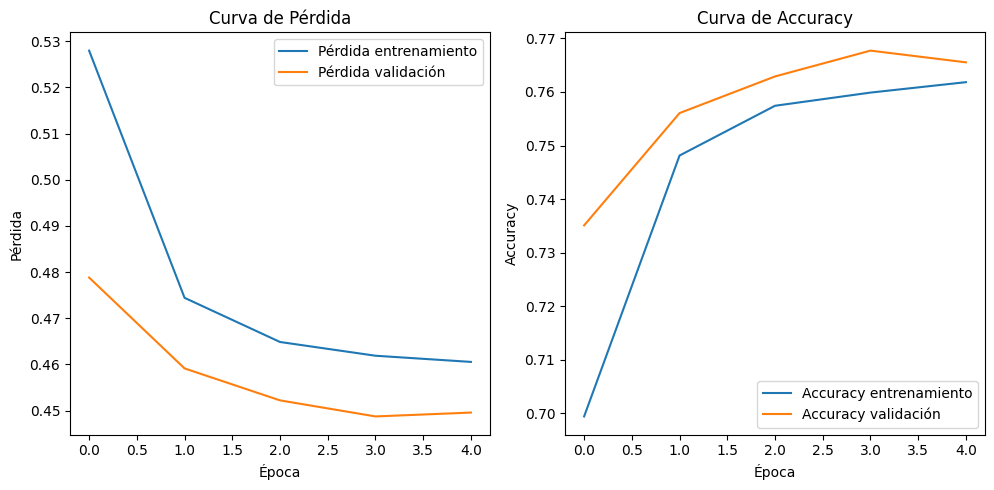

In [8]:
def plot_history(history):
    # Graficar la pérdida
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Pérdida entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida validación')
    plt.title('Curva de Pérdida')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    
    # Graficar la accuracy, si existe
    if 'accuracy' in history.history:
        plt.subplot(1, 3, 2)
        plt.plot(history.history['accuracy'], label='Accuracy entrenamiento')
        plt.plot(history.history['val_accuracy'], label='Accuracy validación')
        plt.title('Curva de Accuracy')
        plt.xlabel('Época')
        plt.ylabel('Accuracy')
        plt.legend()
    # Suponiendo que guardaste la tasa de aprendizaje en un callback personalizado:
    # Por ejemplo, un callback que guarde 'lr' en cada epoch en history.history['lr']

    if 'lr' in history.history:
        # plt.figure(figsize=(6, 5))
        plt.subplot(1, 3, 3)
        plt.plot(history.history['lr'], label='Learning Rate')
        plt.title('Evolución del Learning Rate')
        plt.xlabel('Época')
        plt.ylabel('Learning Rate')
        plt.legend()
        plt.show()

    plt.tight_layout()
    plt.show()

# Llamar a la función para graficar las curvas
plot_history(history)

## Explicabilidad Gradcam

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Similitud predicha: 0.9567785


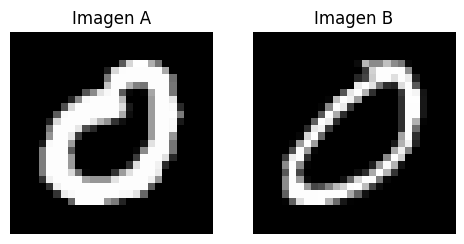

In [11]:

# 4. Función Grad-CAM para explicar la similitud en una de las ramas
def make_gradcam_heatmap(img, paired_img, model_base, base_network, last_conv_layer_name="conv2"):
    """
    Genera un heatmap Grad-CAM para una imagen (img) en la rama 'input_a'
    fijando la segunda imagen (paired_img). Se calcula la derivada del output de similitud
    respecto a la salida de la capa convolucional 'last_conv_layer_name' en el modelo base.
    """
    # Crear un modelo que devuelve las activaciones de la capa last_conv_layer y el embedding final
    grad_model = keras.Model(
        inputs=base_network.input,
        outputs=[base_network.get_layer(last_conv_layer_name).output,
                 base_network.get_layer("embeddings").output]
    )
    # Expandir dimensiones: se espera un batch de 1
    img = tf.expand_dims(img, axis=0)
    paired_img = tf.expand_dims(paired_img, axis=0)
    
    # Obtener embedding de la segunda imagen (fijo)
    emb_b = base_network(paired_img)
    
    with tf.GradientTape() as tape:
        # Registra la activación de la imagen de interés
        conv_outputs, emb_a = grad_model(img)
        # La similitud de coseno se calcula como el producto punto (al estar normalizados)
        cosine_sim = tf.reduce_sum(emb_a * emb_b, axis=1, keepdims=True)
        similarity_score = (cosine_sim + 1) / 2  # escalar a [0,1]
    # Gradiente de la similitud respecto a las activaciones de la capa convolucional
    grads = tape.gradient(similarity_score, conv_outputs)
    # Promediar gradientes en cada mapa (global average pooling)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]  # quitar dimensión batch
    # Ponderar cada canal de la activación por su importancia
    conv_outputs *= pooled_grads
    # Sumar a lo largo de los canales para obtener el heatmap
    heatmap = tf.reduce_sum(conv_outputs, axis=-1)
    heatmap = tf.nn.relu(heatmap)
    # Normalizar el heatmap entre 0 y 1
    # heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    heatmap = tf.divide(heatmap, tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

# Seleccionar un par de imágenes del conjunto de test para visualizar
idx = 120  # índice de ejemplo
img_a = test_pairs[idx, 0]
img_b = test_pairs[idx, 1]

# Mostrar resultados: la imagen original, el heatmap y la superposición
plt.figure(figsize=(12,4))
plt.subplot(1,4,1)
plt.imshow(img_a.squeeze(), cmap='gray')
plt.title("Imagen A")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(img_b.squeeze(), cmap='gray')
plt.title("Imagen B")
plt.axis("off")

# Calcular la similitud predicha
pred_sim = siamese_model.predict([np.expand_dims(img_a, 0), np.expand_dims(img_b, 0)])[0,0]
print("Similitud predicha:", pred_sim)


## Explicacion de Grad CAM

Estas cuatro imágenes ilustran el resultado de aplicar Grad-CAM para entender qué partes de la Imagen A la red siamesa considera más relevantes al compararla con la Imagen B. 

En concreto:

1.	Imagen A: Es la entrada principal que se está analizando.
2.	Imagen B: La referencia con la cual se mide la similitud.
3.	Heatmap Grad-CAM: Muestra, con colores más cálidos (rojos/amarillos), las zonas de la Imagen A que más contribuyen al cálculo de similitud con la Imagen B. Los tonos fríos (azules) indican regiones con menor influencia en la decisión.
4.	Superposición: Combina la Imagen A en escala de grises con el mapa de calor, evidenciando dónde el modelo “mira” para determinar si ambas imágenes representan dígitos similares.

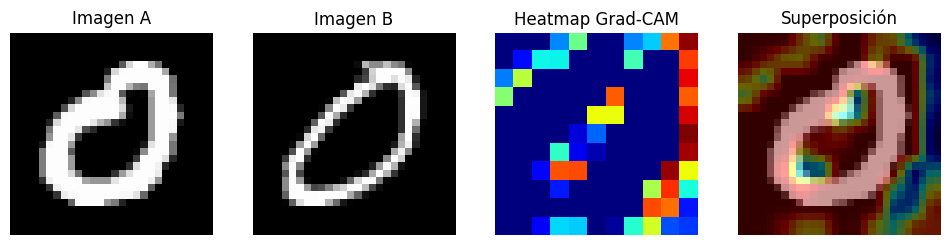

In [12]:

# Generar heatmap de Grad-CAM para la primera imagen, fijando la segunda
heatmap = make_gradcam_heatmap(img_a, img_b, siamese_model, base_network, last_conv_layer_name="conv2")

# Superponer el heatmap sobre la imagen original
def superimpose_heatmap(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    # Reescala el heatmap a las dimensiones de la imagen y lo convierte a uint8 (0-255)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    
    # Convertir la imagen original a 3 canales y a uint8
    img_rgb = np.repeat(img, 3, axis=-1)
    # Si la imagen está en formato float32 (valores entre 0 y 1), se convierte a uint8 (0-255)
    if img_rgb.dtype != np.uint8:
        img_rgb = np.uint8(255 * img_rgb)
    
    # Superponer la imagen y el heatmap con la misma escala y tipo
    superimposed_img = cv2.addWeighted(img_rgb, 1 - alpha, heatmap, alpha, 0)
    return superimposed_img

superimposed_img = superimpose_heatmap(img_a, heatmap)

# Mostrar resultados: la imagen original, el heatmap y la superposición
plt.figure(figsize=(12,4))
plt.subplot(1,4,1)
plt.imshow(img_a.squeeze(), cmap='gray')
plt.title("Imagen A")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(img_b.squeeze(), cmap='gray')
plt.title("Imagen B")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(heatmap, cmap='jet')
plt.title("Heatmap Grad-CAM")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(superimposed_img)
plt.title("Superposición")
plt.axis("off")

plt.show()